In [1]:
# %%time
# Import the libraries
from numpy.random import seed #Ok
seed(42)#Ok
from tensorflow import set_random_seed#Ok
set_random_seed(101)#Ok
import pandas as pd #Ok
import numpy as np #Ok
import tensorflow #Ok 
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam #Ok
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy #Ok
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Ok
from tensorflow.keras.models import Model, Sequential #Ok
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint #Ok
import os, zipfile #Ok
from sklearn.metrics import confusion_matrix #Ok
from sklearn.model_selection import train_test_split #Ok
import itertools #Ok
import shutil #Ok
import matplotlib.pyplot as plt #Ok
%matplotlib inline

import random
from random import random
from random import randrange
from random import choice
from random import uniform
from matplotlib import pyplot
import skimage.io as io
import seaborn as sns
import os
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from os import rename, listdir
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import class_weight
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report
from functools import partial

In [2]:
#Seting the data directories
dir_zip = r'D:\Python\Jupyter\DeepLearning\MobileNet\zipFiles'
dir_database = r'D:\Python\Jupyter\DeepLearning\MobileNet\DataBase'
dir_MetaData = r'D:\Python\Jupyter\DeepLearning\MobileNet\metaData_dataBase'
dir_project = r'D:\Python\Jupyter\DeepLearning\MobileNet'

#### Unzipping the Images

In [3]:
#%%time
extension = ".zip"

os.chdir(dir_zip) # change directory from working dir to dir with files

if len(os.listdir(os.path.abspath(dir_database)))==0 or len(os.listdir(os.path.abspath(dir_database)))==1:
    # Loop to extract all Images from a the zip file on directory
    for item in os.listdir(dir_zip): # loop through items in dir
        if item.endswith(extension): # check for ".zip" extension
            file_name = os.path.abspath(item) # get full path of files
            print("Processing %s" % file_name)
            zip_ref = zipfile.ZipFile(file_name) # create zipfile object
            os.chdir(dir_zip) # change directory from working dir to dir with files
            zip_ref.extractall(dir_database) # extract file to dir
            zip_ref.close() # close file
            #os.remove(file_name) # delete zipped file
else:
    print(len(os.listdir(os.path.abspath(dir_database))))

10018


In [4]:
metadata = pd.read_csv(dir_MetaData+'/HAM10000_metadata.csv', header=0, index_col=1)

In [5]:
metadata.head()

,lesion_id,dx,dx_type,age,sex,localization
image_id,,,,,,
ISIC_0027419,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0025030,HAM_0000118,bkl,histo,80.0,male,scalp
ISIC_0026769,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0025661,HAM_0002730,bkl,histo,80.0,male,scalp
ISIC_0031633,HAM_0001466,bkl,histo,75.0,male,ear


In [6]:
# Categories of the diferent diseases
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
metadata.dx=metadata.dx.astype('category',copy=True)
metadata['labels']=metadata.dx.cat.codes # Convert the labels to numbers
metadata['lesion']= metadata.dx.map(lesion_type_dict)
# metadata.head()

In [8]:
print(metadata.lesion.value_counts())

Melanocytic nevi        6705
Melanoma                1113
Benign keratosis        1099
Basal cell carcinoma     514
Actinic keratoses        327
Vascular lesions         142
Dermatofibroma           115
Name: lesion, dtype: int64


In [9]:
metadata.loc['ISIC_0025084','lesion']

'Melanocytic nevi'

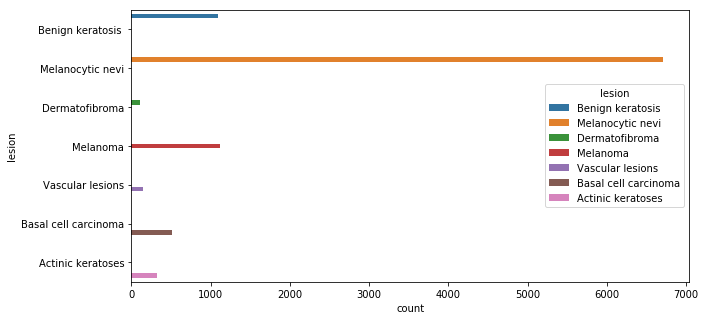

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
sns.countplot(y='lesion',data=metadata, hue="lesion",ax=ax1)

In [11]:
# Create a list of file names
#-------------------------------------------------#
filenames = [os.path.splitext(filename)[0] for filename in os.listdir(dir_database) if filename.endswith(".jpg")]
prov_filenames = []
for name in filenames:
    prov_filenames.append(name[-12:])
filenames = prov_filenames
filenames = pd.DataFrame(np.array(filenames).reshape(10015,1),columns=['filenames'])
# filenames = pd.DataFrame(np.array(filenames).reshape(2000,1),columns=['filenames'])

In [12]:
# # Organize dataset according to photos actual order
# ----------------------------------------------------
# # Merging the file names and the metadata, thus organizing the data.

organized_metadata = pd.merge(left=filenames, right=metadata, left_on='filenames',right_on='image_id')
# # print(organized_metadata)

In [13]:
organized_metadata['dx'] = organized_metadata['dx'].astype(np.str)
organized_metadata['filenames'] = organized_metadata['filenames'].astype(np.str)

In [14]:
# It removes all metadata but dx (lesion type)
organized_metadata['filenames_dx'] = organized_metadata['dx'] + '_' + organized_metadata['filenames']

In [15]:
# this will tell us how many images are associated with each lesion_id
df = organized_metadata.groupby('lesion_id').count()

# now we filter out lesion_id's that have only one image associated with it
df = df[df['filenames'] == 1]
df.reset_index(inplace=True)
# df.head()

In [16]:
# Identifing the lesions who has more than one image on the dataset
def identify_duplicates(x):    
    unique_list = list(df['lesion_id'])    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'

In [17]:
# create a new colum that is a copy of the lesion_id column
organized_metadata['duplicates'] = organized_metadata['lesion_id']
# apply the function to this new column
organized_metadata['duplicates'] = organized_metadata['duplicates'].apply(identify_duplicates)
organized_metadata.head()

,filenames,lesion_id,dx,dx_type,age,sex,localization,labels,lesion,filenames_dx,duplicates
0,ISIC_0024329,HAM_0002954,akiec,histo,75.0,female,lower extremity,0,Actinic keratoses,akiec_ISIC_0024329,no_duplicates
1,ISIC_0024372,HAM_0005389,akiec,histo,70.0,male,lower extremity,0,Actinic keratoses,akiec_ISIC_0024372,has_duplicates
2,ISIC_0024418,HAM_0003380,akiec,histo,75.0,female,lower extremity,0,Actinic keratoses,akiec_ISIC_0024418,has_duplicates
3,ISIC_0024450,HAM_0005505,akiec,histo,50.0,male,upper extremity,0,Actinic keratoses,akiec_ISIC_0024450,has_duplicates
4,ISIC_0024463,HAM_0004568,akiec,histo,50.0,male,upper extremity,0,Actinic keratoses,akiec_ISIC_0024463,has_duplicates


In [18]:
organized_metadata['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [19]:
# now we filter out images that don't have duplicates
metadataNotDuplicates = organized_metadata[organized_metadata['duplicates'] == 'no_duplicates']
# metadataNotDuplicates.shape

In [20]:
# #%%time
# # Labels
# #%%time
labelsNotDuplicates = np.array(metadataNotDuplicates['dx'].tolist())
filenamesNotDuplicates = np.array(metadataNotDuplicates['filenames_dx'].tolist())
print(len(labelsNotDuplicates))

labels = np.array(organized_metadata['dx'].tolist())
filenames = np.array(organized_metadata['filenames_dx'].tolist())
print(len(labels))

5514
10015


In [21]:
# Creating Train / Val / Test folders (One time use)
lesionstype = ['nv','mel',"vasc",'akiec','bcc','bkl','df']

In [22]:
os.chdir(dir_database)

In [23]:
# %%time
def list_files(path):
    # returns a list of names (with extension, without full path) of all files 
    # in folder path
    files = []
    for name in os.listdir(path):
        if os.path.isfile(os.path.join(path, name)):
            files.append(name)
    return files 

In [24]:
images = list_files('.')

In [25]:
for img, extra in zip(images, labels) :
    filename, extension = os.path.splitext(img)
    if filename.startswith("ISIC_"):
        os.rename(img, ''.join([extra, '_', filename, extension]))
#     print(img)

In [26]:
# Shuffle the data order:
organized_metadata = organized_metadata.sample(frac=1).reset_index(drop=True)

#### Separating only lesions with just unique images for Validation and Testing

In [27]:
x, data_validate, y, label_validate = train_test_split(filenamesNotDuplicates,                                           
                                                       labelsNotDuplicates, 
                                                        test_size=0.40, 
                                                        random_state=42, 
                                                        stratify=labelsNotDuplicates)

del(x)
del(y)

In [28]:
len(data_validate)

2206

In [29]:
# here we identify lesion_id's that have duplicate images and those that have only
# one image.

def train_image_detection(x):    
    data_validate_list = list(data_validate)    
    if x in data_validate_list:
        return 'validate_test'
    else:
        return 'train'

In [30]:
# create a new colum that is a copy of the lesion_id column
organized_metadata['set'] = organized_metadata['filenames_dx']
# apply the function to this new column
organized_metadata['set'] = organized_metadata['set'].apply(train_image_detection)


In [31]:
# Using the rest of the images as the training set
provisorio = organized_metadata[organized_metadata['set'] == 'train']
train_filenames = provisorio['filenames_dx']+'.jpg'
train_filenames = train_filenames.tolist()
label_train = provisorio['dx']
label_train = label_train.tolist()
del(provisorio)

In [32]:
# Spliting the images with no repetition into Test and Validation Set
data_validate, data_test, label_validate, label_test = train_test_split(data_validate, label_validate, 
                                                                  test_size=0.5, 
                                                                  random_state=42, 
                                                                  stratify=label_validate)

In [33]:
data_validate = pd.Series(data_validate)+'.jpg'
data_test = pd.Series(data_test)+'.jpg'

In [34]:
val_filenames = [name for name in data_validate.tolist()]
test_filenames = [name for name in data_test.tolist()]

In [35]:
print('Separation of images for training, validation and testing: ')
print()
print('Total labels: ', len(labels))
perc_label_validate = round(100*(len(label_validate))/len(labels),1)
print('Validation_labels: ', len(label_validate), ' - ',perc_label_validate,'%')
perc_label_test = round(100*(len(label_test))/len(labels),1)
print('Testing_labels: ', len(label_test), ' - ',perc_label_test,'%')
perc_label_train = round(100*(len(label_train))/len(labels),1)
print('Trainning_labels: ', len(label_train), ' - ',perc_label_train,'%')
print()
print('Total images: ', len(filenames))
perc_val_filenames = round(100*(len(val_filenames))/len(filenames),1)
print('Validation Images: ', len(val_filenames), ' - ',perc_val_filenames,'%')
perc_test_filenames = round(100*(len(test_filenames))/len(filenames),1)
print('Testing Images: ', len(test_filenames), ' - ',perc_test_filenames,'%')
perc_train_train = round(100*(len(train_filenames))/len(filenames),1)
print('Trainning Images: ', len(train_filenames), ' - ',perc_train_train,'%')

Separation of images for training, validation and testing: 

Total labels:  10015
Validation_labels:  1103  -  11.0 %
Testing_labels:  1103  -  11.0 %
Trainning_labels:  1103  -  78.0 %

Total images:  10015
Validation Images:  1103  -  11.0 %
Testing Images:  1103  -  11.0 %
Trainning Images:  7809  -  78.0 %


In [36]:
unique_elements, counts_elements = np.unique(label_train, return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
 ['267' '444' '923' '99' '1021' '4939' '116']]


In [37]:
os.chdir(dir_database)

In [38]:
# %%time
# # Copy-pasting images: for train, validation and test

envs = dict()
envs['train'] = train_filenames
envs['test'] = test_filenames
envs['val'] = val_filenames

for env in envs:
    if not os.path.isdir(dir_database +'/'+ env): os.makedirs(dir_database +'/'+ env)
    for i in lesionstype:   
        print('Analysing '+ env + ' ' + i + ' Lesions')
        if not os.path.isdir(dir_database + '/'+env+'/' + i): os.makedirs(dir_database + '/'+env+'/' + i)
        if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/' + i)))<=1:
            for name in envs[env]:
                if name.startswith(i):
                    shutil.copy(name, dir_database+"/"+env+"/"+i+"/")
        print(env+' '+i+' lesions images: '+ str(len(os.listdir(os.path.abspath(dir_database + '/'+env+'/' + i)))))
    print()
    print('---- / / ----')

Analysing train nv Lesions
train nv lesions images: 4939
Analysing train mel Lesions
train mel lesions images: 4939
Analysing train vasc Lesions
train vasc lesions images: 4939
Analysing train akiec Lesions
train akiec lesions images: 4939
Analysing train bcc Lesions
train bcc lesions images: 4939
Analysing train bkl Lesions
train bkl lesions images: 4939
Analysing train df Lesions
train df lesions images: 4939

---- / / ----
Analysing test nv Lesions
test nv lesions images: 883
Analysing test mel Lesions
test mel lesions images: 46
Analysing test vasc Lesions
test vasc lesions images: 13
Analysing test akiec Lesions
test akiec lesions images: 30
Analysing test bcc Lesions
test bcc lesions images: 35
Analysing test bkl Lesions
test bkl lesions images: 88
Analysing test df Lesions
test df lesions images: 8

---- / / ----
Analysing val nv Lesions
val nv lesions images: 883
Analysing val mel Lesions
val mel lesions images: 46
Analysing val vasc Lesions
val vasc lesions images: 13
Analysin

In [39]:
# check how many train images we have in each folder

print('nv - ',len(os.listdir(dir_database+'/train/nv')))
print('mel - ',len(os.listdir(dir_database+'/train/mel')))
print('bkl - ',len(os.listdir(dir_database+'/train/bkl')))
print('bcc - ',len(os.listdir(dir_database+'/train/bcc')))
print('akiec - ',len(os.listdir(dir_database+'/train/akiec')))
print('vasc - ',len(os.listdir(dir_database+'/train/vasc')))
print('df - ',len(os.listdir(dir_database+'/train/df')))

nv -  4939
mel -  4939
bkl -  4939
bcc -  4939
akiec -  4939
vasc -  4939
df -  4939


In [40]:
train_path = dir_database+"/train"
val_path = dir_database+"/val"
test_path = dir_database+"/test"

In [41]:
# datagen = ImageDataGenerator(
#         rotation_range=randrange(0, 180, 5),
#         width_shift_range=uniform(0.1,0.3),
#         height_shift_range=uniform(0.1,0.3),
# #         shear_range=uniform(0.05,0.4),
#         zoom_range=uniform(0.1,0.3),
#         horizontal_flip=choice([True, False]),
#         vertical_flip=choice([True, False]),
#         fill_mode='nearest')

In [42]:
# dir_zip = r'D:\Python\Jupyter\DeepLearning\MobileNet2\zipFiles'
# dir_database = r'D:\Python\Jupyter\DeepLearning\MobileNet2\DataBase'
# dir_MetaData = r'D:\Python\Jupyter\DeepLearning\MobileNet2\metaData_dataBase'
# dir_project = r'D:\Python\Jupyter\DeepLearning\MobileNet2'

In [43]:
base_dir=dir_database

In [44]:
%%time
envs = dict()
envs['train'] = train_filenames
# envs['test'] = test_filenames
# envs['val'] = val_filenames


for env in envs:
    print(env)
    nvFolderSize = len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+'nv')))
    for i in lesionstype:   
        print('Balancing '+ env + ' ' + i + ' Lesions')
        os.chdir(dir_database + '/'+env+'/'+i)
        print('Data From... '+os.getcwd())
        if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i)))<nvFolderSize:
            print(nvFolderSize)
            print(len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i))))
            print('...')
            images = io.ImageCollection(dir_database + '/'+env+'/'+i+'/'+i+'*', conserve_memory=True, load_func=None)
            images = io.concatenate_images(images)
            print('......')

            for batch in datagen.flow(images, batch_size=1,
                                      save_to_dir=dir_database + '/'+env+'/'+i, save_prefix='aug', save_format='jpeg'):
    #                 print('.........')
                if len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i)))==nvFolderSize:
                    print('.........')
                    break  # otherwise the generator would loop indefinitely
            print(len(os.listdir(os.path.abspath(dir_database + '/'+env+'/'+i))))                
            print('--//--')
print('Finnish!')

train
Balancing train nv Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\nv
Balancing train mel Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\mel
Balancing train vasc Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\vasc
Balancing train akiec Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\akiec
Balancing train bcc Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\bcc
Balancing train bkl Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\bkl
Balancing train df Lesions
Data From... D:\Python\Jupyter\DeepLearning\MobileNet\DataBase\train\df
Finnish!
Wall time: 108 ms


In [45]:
# Declare a few useful values
num_train_samples = sum([len(files) for r, d, files in os.walk(train_path)]) #len(train_filenames) 
num_val_samples = sum([len(files) for r, d, files in os.walk(val_path)]) #len(val_filenames)
num_test_samples = sum([len(files) for r, d, files in os.walk(test_path)]) #len(test_filenames)
train_batch_size = 10
val_batch_size = 10
test_batch_size = 1

image_width = 224
image_height = 224

In [46]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

In [47]:
# Declare how many steps are needed in an iteration
train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
test_steps = np.ceil(num_test_samples / val_batch_size)

In [48]:
print(train_steps, val_steps, test_steps)

3458.0 111.0 111.0


### Set Up the generator batches

#### Train Batches

In [49]:
# Set up generators
print('Train Batches: ')

train_batches = datagen.flow_from_directory(
    train_path,
    target_size=(image_height, image_width),
    batch_size=train_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Train Batches: 
Found 34573 images belonging to 7 classes.


#### Validation Batches

In [50]:
print('Validation Batches: ')
val_batches = datagen.flow_from_directory(
    val_path,
    target_size=(image_height, image_width),
    batch_size=val_batch_size,
    class_mode = 'categorical',
    classes = lesionstype)

Validation Batches: 
Found 1103 images belonging to 7 classes.


#### Test Batches

In [51]:
print('Test Batches: ')
test_batches = datagen.flow_from_directory(
    test_path,
    target_size=(image_height, image_width),
    batch_size=test_batch_size,
    class_mode = 'categorical',
    classes = lesionstype,
    shuffle = False)

Test Batches: 
Found 1103 images belonging to 7 classes.


In [52]:
for data_batch, labels_batch in train_batches:
    print('Train: data batch shape:', data_batch.shape)
    print('Train: labels batch shape:', labels_batch.shape)
    print('--//--')
    break
    
for data_batch, labels_batch in val_batches:
    print('Validation: data batch shape:', data_batch.shape)
    print('Validation: labels batch shape:', labels_batch.shape)
    print('--//--')
    break
    
for data_batch, labels_batch in test_batches:
    print('Test: data batch shape:', data_batch.shape)
    print('Test: labels batch shape:', labels_batch.shape)
    print('--//--')
    break

Train: data batch shape: (10, 224, 224, 3)
Train: labels batch shape: (10, 7)
--//--
Validation: data batch shape: (10, 224, 224, 3)
Validation: labels batch shape: (10, 7)
--//--
Test: data batch shape: (1, 224, 224, 3)
Test: labels batch shape: (1, 7)
--//--


## Sample Weights

In [53]:
from sklearn.utils.class_weight import compute_class_weight

In [54]:
class_weights = compute_class_weight("balanced", lesionstype, label_train)


In [55]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 1.0, # mel
    5: 1.0, # nv
    6: 1.0, # vasc
}

## Precision / Recall / F-Measure

In [56]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

In [57]:
# Check how many train images we now have in each folder.
# This is the original images plus the augmented images.
print('Balanced Train Dataset')
print()
print('nv - ',len(os.listdir(base_dir+'/train/nv')))
print('mel - ',len(os.listdir(base_dir+'/train/mel')))
print('bkl - ',len(os.listdir(base_dir+'/train/bkl')))
print('bcc - ',len(os.listdir(base_dir+'/train/bcc')))
print('akiec - ',len(os.listdir(base_dir+'/train/akiec')))
print('vasc - ',len(os.listdir(base_dir+'/train/vasc')))
print('df - ',len(os.listdir(base_dir+'/train/df')))

Balanced Train Dataset

nv -  4939
mel -  4939
bkl -  4939
bcc -  4939
akiec -  4939
vasc -  4939
df -  4939


### Custom Metrics 

In [58]:
def precision(y_true, y_pred):
    """Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    """Computes the F score.
    The F score is the weighted harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.

    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    """

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')

    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    """Computes the f-measure, the harmonic mean of precision and recall.
    Here it is only computed as a batch-wise average, not globally.
    """
    return fbeta_score(y_true, y_pred, beta=1)

##  MobileNet


In [137]:
# create a copy of a mobilenet model
mobile = tensorflow.keras.applications.mobilenet.MobileNet(dropout=1e-3, pooling=max)

In [138]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [139]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
# x = BatchNormalization()(x)
predictions = Dense(7, activation='softmax')(x)

mobile = Model(inputs=mobile.input, outputs=predictions)

In [140]:
type(mobile.layers)

list

In [141]:
# How many layers does MobileNet have?
len(mobile.layers)

90

In [144]:
# Number of Layers that will be trained
for layer in mobile.layers[:-20]:
    layer.trainable = False

In [145]:
# model.summary()

In [146]:
mobile.compile(Adam(lr=0.01)
              ,loss='categorical_crossentropy'
              ,metrics=[categorical_accuracy, precision, recall, fmeasure])

In [147]:
# Get the labels that are associated with each index
print(train_batches.class_indices)
print(val_batches.class_indices)
print(test_batches.class_indices)

{'nv': 0, 'mel': 1, 'vasc': 2, 'akiec': 3, 'bcc': 4, 'bkl': 5, 'df': 6}
{'nv': 0, 'mel': 1, 'vasc': 2, 'akiec': 3, 'bcc': 4, 'bkl': 5, 'df': 6}
{'nv': 0, 'mel': 1, 'vasc': 2, 'akiec': 3, 'bcc': 4, 'bkl': 5, 'df': 6}


## Checkpoint / Learning Rate / Callback 

In [148]:
# Filepath to save the model
os.chdir(dir_project)
filepath = "mobileNet.h5"

In [149]:
# Declare a checkpoint to save the best version of the model
checkpoint = ModelCheckpoint(filepath, 
                             monitor='val_fmeasure', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

# Reduce the learning rate as the learning stagnates
reduce_lr = ReduceLROnPlateau(monitor='val_fmeasure'
                              ,factor=0.5
                              ,patience=2
                              ,verbose=1
                              ,mode='max'
                              ,min_lr=0.00001)
# Eearly Stop
earlystopping = EarlyStopping(monitor='val_fmeasure',
                              min_delta=0,
                              patience=5,
                              verbose=0, 
                              mode='max')

callbacks_list = [checkpoint, reduce_lr, earlystopping]

In [150]:
config = tensorflow.ConfigProto()
config.gpu_options.allow_growth = True

session = tensorflow.Session(config=config)

In [151]:
history = mobile.fit_generator(train_batches
                              ,steps_per_epoch=train_steps
                              ,class_weight=class_weights
                              ,validation_data=val_batches
                              ,validation_steps=val_steps
                              ,epochs=20
                              ,verbose=1
                              ,callbacks=callbacks_list) 

Epoch 1/20
111/111 [==============================] - 15s 139ms/step - loss: 0.7801 - categorical_accuracy: 0.8042 - precision: 0.8107 - recall: 0.8054 - fmeasure: 0.8079

Epoch 00001: val_fmeasure improved from -inf to 0.80792, saving model to mobileNet.h5
3458/3458 [==============================] - 329s 95ms/step - loss: 0.9304 - categorical_accuracy: 0.6611 - precision: 0.7420 - recall: 0.5775 - fmeasure: 0.6441 - val_loss: 0.7801 - val_categorical_accuracy: 0.8042 - val_precision: 0.8107 - val_recall: 0.8054 - val_fmeasure: 0.8079
Epoch 2/20
111/111 [==============================] - 15s 136ms/step - loss: 0.7045 - categorical_accuracy: 0.8024 - precision: 0.8232 - recall: 0.7982 - fmeasure: 0.8099

Epoch 00002: val_fmeasure improved from 0.80792 to 0.80987, saving model to mobileNet.h5
3458/3458 [==============================] - 345s 100ms/step - loss: 0.6540 - categorical_accuracy: 0.7572 - precision: 0.8142 - recall: 0.6958 - fmeasure: 0.7470 - val_loss: 0.7045 - val_categoric

In [153]:
# get the metric names so we can use evaulate_generator
mobile.metrics_names

['loss', 'categorical_accuracy', 'precision', 'recall', 'fmeasure']

In [154]:
# Here the the last epoch will be used.

val_loss, val_cat_acc, val_precision, val_recall, val_fmeasure = \
mobile.evaluate_generator(test_batches, 
                        steps=len(label_validate))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_fmeasure:', val_fmeasure)

val_loss: 0.6511242810962221
val_cat_acc: 0.82683593
val_precision: 0.8005439
val_recall: 0.8005439
val_fmeasure: 0.8005439


In [155]:
# # Here the best epoch will be used.

model.load_weights('mobileNet.h5')

val_loss, val_cat_acc, val_precision, val_recall, val_fmeasure = \
mobile.evaluate_generator(test_batches, 
                        steps=len(label_validate))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_precision:', val_precision)
print('val_recall:', val_recall)
print('val_fmeasure:', val_fmeasure)

val_loss: 0.6511242810962221
val_cat_acc: 0.82683593
val_precision: 0.8005439
val_recall: 0.8005439
val_fmeasure: 0.8005439


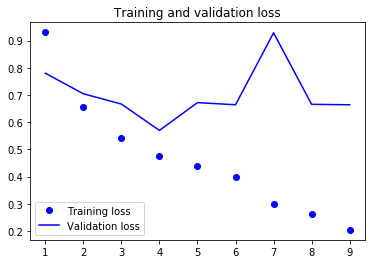

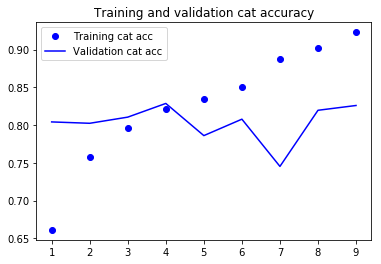

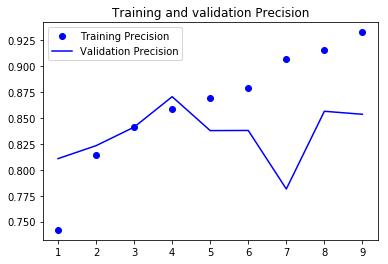

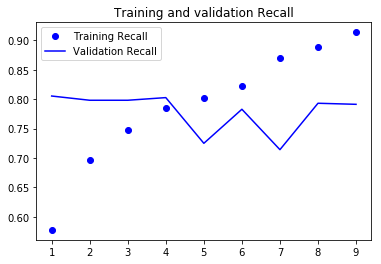

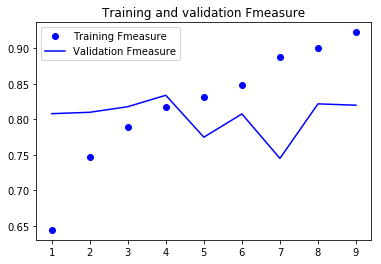

In [156]:
# display the loss and accuracy curves

import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# val_loss, val_cat_acc, val_precision, val_recall, val_fmeasure

train_precision = history.history['precision']
val_precision = history.history['val_precision']
train_recall = history.history['recall']
val_recall = history.history['val_recall']
train_fmeasure = history.history['fmeasure']
val_fmeasure = history.history['val_fmeasure']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, train_precision, 'bo', label='Training Precision')
plt.plot(epochs, val_precision, 'b', label='Validation Precision')
plt.title('Training and validation Precision')
plt.legend()
plt.figure()
plt.plot(epochs, train_recall, 'bo', label='Training Recall')
plt.plot(epochs, val_recall, 'b', label='Validation Recall')
plt.title('Training and validation Recall')
plt.legend()
plt.figure()
plt.plot(epochs, train_fmeasure, 'bo', label='Training Fmeasure')
plt.plot(epochs, val_fmeasure, 'b', label='Validation Fmeasure')
plt.title('Training and validation Fmeasure')
plt.legend()

plt.show()

Confusion Matrix

In [65]:
# Source: Scikit Learn website
# http://scikit-learn.org/stable/auto_examples/
# model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-
# selection-plot-confusion-matrix-py


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

#### Confusion Matrix - Test Data

1103/1103 [==============================] - 19s 17ms/step
Normalized confusion matrix
[[0.84597961 0.05096263 0.00226501 0.         0.04756512 0.0011325
  0.05209513]
 [0.2173913  0.58695652 0.         0.         0.15217391 0.
  0.04347826]
 [0.38461538 0.         0.38461538 0.         0.23076923 0.
  0.        ]
 [0.16666667 0.46666667 0.         0.03333333 0.13333333 0.03333333
  0.16666667]
 [0.02857143 0.14285714 0.         0.         0.8        0.
  0.02857143]
 [0.18181818 0.43181818 0.         0.         0.17045455 0.07954545
  0.13636364]
 [0.25       0.         0.         0.         0.         0.
  0.75      ]]


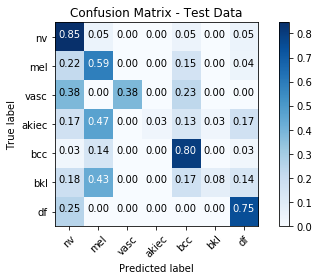

In [160]:
# Get the labels of the test images.
test_labels = test_batches.classes

# We need these to plot the confusion matrix.
# test_labels
# make a prediction
predictions = mobileNet.predict_generator(test_batches, steps=len(label_test), verbose=1)
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
test_batches.class_indices
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = test_batches.class_indices
plot_confusion_matrix(cm, cm_plot_labels, normalize=True, title='Confusion Matrix - Test Data')

Confusion matrix, without normalization
[[747  45   2   0  42   1  46]
 [ 10  27   0   0   7   0   2]
 [  5   0   5   0   3   0   0]
 [  5  14   0   1   4   1   5]
 [  1   5   0   0  28   0   1]
 [ 16  38   0   0  15   7  12]
 [  2   0   0   0   0   0   6]]


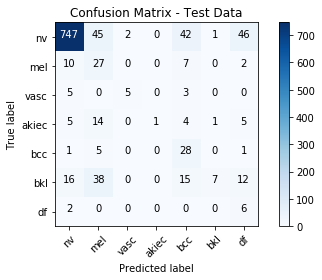

In [161]:
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix - Test Data')

In [162]:
test_batches.class_indices

{'nv': 0, 'mel': 1, 'vasc': 2, 'akiec': 3, 'bcc': 4, 'bkl': 5, 'df': 6}

#### Classification Report

In [163]:
# Get the index of the class with the highest probability score
y_pred = np.argmax(predictions, axis=1)

# Get the labels of the test images.
y_true = test_batches.classes

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=cm_plot_labels)
print(report)

              precision    recall  f1-score   support

          nv       0.95      0.85      0.90       883
         mel       0.21      0.59      0.31        46
        vasc       0.71      0.38      0.50        13
       akiec       1.00      0.03      0.06        30
         bcc       0.28      0.80      0.42        35
         bkl       0.78      0.08      0.14        88
          df       0.08      0.75      0.15         8

   micro avg       0.74      0.74      0.74      1103
   macro avg       0.57      0.50      0.35      1103
weighted avg       0.88      0.74      0.76      1103

